#<center><strong>Flock Jr Data Scientist Project</strong></center>
##<center><strong>By Akintoye Adesomoju</strong></center>
<img src = 'https://securecdn.pymnts.com/wp-content/uploads/2021/04/Allica-Bank-relationship-manager.jpg' >

###**What is the dillema?**

A finance company has purchased a portfolio of charged off debt – meaning that Bank A, B, or C has loaned money to the people in this file, but the customers did not pay back the loan as agreed. 

The Bank has sold the debt to the finance company.

At this point, the finance company is trying to assess which bank (A, B or C) is the most profitable relationship.

####<strong>How can we help?</strong>

We will first have to understand the data, then perform accurate analysis and draw insights based on what the data is telling us. 

###<strong>Dataset</strong>

The data was provided to me by Jennifer. While I could just upload the excel file directly to this notebook to work with, for the sake of showing my SQL/Cloud skills I will be using IBMS Db2. It should closely resemble the Azure environment you use in the office. 

In [ ]:
!pip install ibm_db
!pip install ibm_db_sa
import ibm_db
import ibm_db_sa
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
%load_ext sql

In [3]:
%sql ibm_db_sa://nwp64039:MyPassword@b1bc1829-6f45-4cd4-bef4-10cf081900bf.c1ogj3sd0tgtu0lqde00.databases.appdomain.cloud:32304/BLUDB;security=SSL

'Connected: nwp64039@BLUDB;security=SSL'

After I connected My notebook to my Db2 database I encountered my first issue. While attempting to upload the CSV file to IBM Cloud, I kept getting permission errors. I was not sure why as I use this DB quite often and spent the better part of 3-4 hours trying to contact IBM to fix this issue/Find online help. It unfortunately was not resolved but I decided I would just put in #comments the SQL commands I would have used anyways. So hopefully it satisisfies.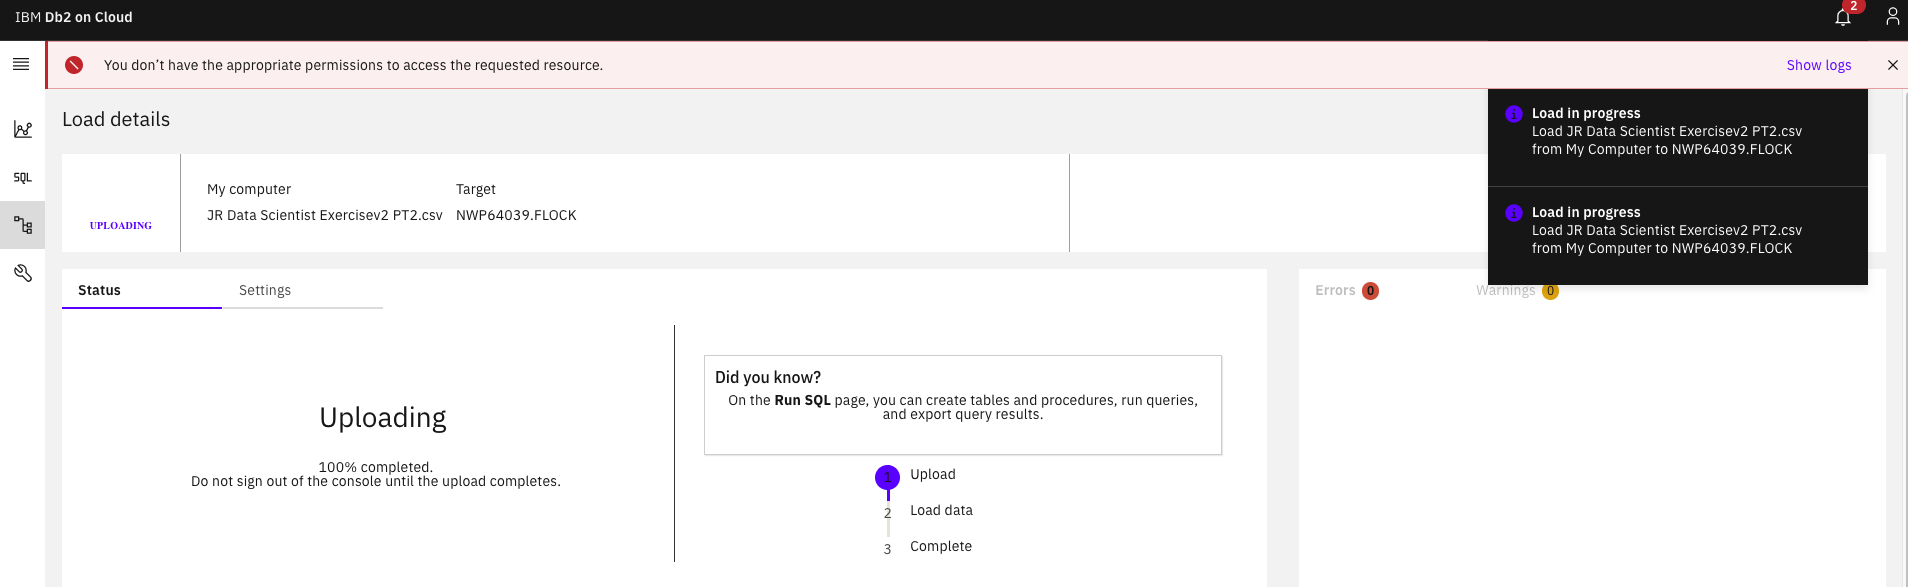

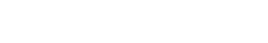


**Loading the data in pandas**




In [4]:
df = pd.read_csv('JR Data Scientist Exercisev2 PT2.csv')
df.drop(labels='Unnamed: 6', axis=1, inplace = True)
df.sample(10)

,CUSTOMER ID,Customer Date Last Paid,Cumulative Payment To Date,Account Open Date,Original Principal,ORIGINATOR
2743,26414,NaN,$0.00,12/25/2020,"$1,950.00",A
907,8545,NaN,$0.00,3/12/2022,"$2,349.00",A
1392,68402,NaN,$961.80,5/12/2022,"$2,290.00",C
4075,50201,4/15/2022,$45.47,7/26/2021,$800.00,B
82,66459,NaN,"$2,325.54",12/14/2021,"$5,537.00",C
9624,73561,NaN,$0.00,5/10/2022,$33.75,B
1120,56624,NaN,$0.00,5/23/2022,"$2,349.00",B
8840,14145,NaN,$0.00,3/29/2022,$36.23,A
270,82527,NaN,$0.00,2/27/2022,"$3,050.00",B
7856,70893,NaN,$0.00,4/12/2022,$44.04,C


We can see multiple null values and the currency is set as a string, for later analysis we will have to fix these

In [5]:
count = 1

for col in df.columns:
  print(f'{count}. {col}')
  count += 1

1. CUSTOMER ID
2. Customer Date Last Paid
3. Cumulative Payment To Date
4. Account Open Date
5.   Original Principal  
6. ORIGINATOR


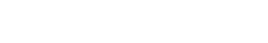

The first thing we need to do is understand the data. The columns and their definitions are as follows:

**Customer ID** = Unique identifier (n=10,438)

**Customer Date Last Paid** = Last Date of Payment

**Cumulative Payment To-Date** = Total Amount Received To-Date from Customer

**Account Open Date** = Date account was opened

**Original Principal** = Amount of the original loan

**ORIGINATOR** = source of the loan (i.e., Bank A, B or C)



In [6]:
df.dtypes

CUSTOMER ID                    int64
Customer Date Last Paid       object
Cumulative Payment To Date    object
Account Open Date             object
  Original Principal          object
ORIGINATOR                    object
dtype: object

Checking the amount of NAN/null values

In [20]:
df.isna().sum()

CUSTOMER ID                      0
Customer Date Last Paid       5726
Cumulative Payment To Date     227
Account Open Date                0
  Original Principal             0
ORIGINATOR                       0
dtype: int64

We can see that while the date they last paid is filled with Null values, the rest of them are relatively clean, with Cumulative payment being the only column with nulls. When visualizing we might drop this column as it would provide issues

###<strong>Solving the Problem</strong>

Let us clean the data a bit to help later

In [ ]:
df['Cumulative Payment To Date'] = df['Cumulative Payment To Date'].str.replace('$','')
df['Cumulative Payment To Date'] = df['Cumulative Payment To Date'].str.replace(',','')
df['Cumulative Payment To Date'] = df['Cumulative Payment To Date'].astype('float')
df['  Original Principal  '] = df['  Original Principal  '].str.replace('$','')
df['  Original Principal  '] = df['  Original Principal  '].str.replace(',','')
df['  Original Principal  '] = df['  Original Principal  '].astype('float')
df

We would need to split the data before we could calculate profit

In [9]:
# SQL: originA_df =  %sql SELECT * FROM FLOCK_DATA WHERE ORIGINATOR LIKE 'A'

originA_df = df[df['ORIGINATOR'] == 'A']
originB_df = df[df['ORIGINATOR'] == 'B']
originC_df = df[df['ORIGINATOR'] == 'C']

Next we want to count the total amount of loans from each bank

In [10]:
originA_df.describe()

,CUSTOMER ID,Cumulative Payment To Date,Original Principal
count,3480.000000,3410.000000,3480.000000
mean,50331.145115,18.839381,888.593609
std,28544.290751,35.291048,1042.746869
min,36.000000,0.000000,25.000000
25%,25629.500000,0.000000,44.167500
50%,51293.000000,0.000000,184.000000
75%,74602.750000,24.407500,2028.000000
max,99911.000000,296.000000,6542.000000


We can see that for Bank A there are **3480** customers who defaulted. The average amount they owe is around 900 USD and the average amount of payments they have made is **20** USD

In [11]:
originB_df.describe()

,CUSTOMER ID,Cumulative Payment To Date,Original Principal
count,3465.000000,3382.000000,3465.000000
mean,50487.682251,37.488752,913.915506
std,28820.569400,75.855842,1163.022514
min,58.000000,0.000000,25.000000
25%,25989.000000,0.000000,43.480000
50%,50915.000000,0.000000,184.000000
75%,75441.000000,43.750000,2050.000000
max,99965.000000,630.480000,11352.000000


We can see that for Bank B there are **3465** customers who defaulted. The average amount they owe is around **910** USD and the average amount of payments they have made is **40** USD

In [12]:
originC_df.describe()

,CUSTOMER ID,Cumulative Payment To Date,Original Principal
count,3493.000000,3419.000000,3493.000000
mean,49047.471228,318.966356,1039.456693
std,28752.892399,560.953723,1343.262245
min,18.000000,0.000000,25.000000
25%,24106.000000,0.000000,46.610000
50%,49096.000000,13.320000,319.000000
75%,73563.000000,566.735000,2089.000000
max,99983.000000,4987.080000,11874.000000


Finally, We can see that for Bank C there are **3493** customers who defaulted. The average amount they owe is around **1040** USD and the average amount of payments they have made is **318** USD. It seems Bank C could be making better choices with the customers they have as they have a higher rate of payment than other banks. This theory should be experimented as it could be due to outliers for both banks skewing the data. 

**Calculating profit for each bank**

In order to find the profit for each bank we would need to use the formula PROFIT = (Cumulative Payment To Date) - (Original Principal*.05) – ($10 per 1000 accounts
purchased). We will need to define our variables, which would be:

Total Cumulative Payment (For each bank)

Total Principal (For each bank)

Because we have some null values we will have to drop them


In [13]:
# Total Principal Bank A

Ttl_Pr_A = 0
for row in originA_df['  Original Principal  ']:
  Ttl_Pr_A += row
print(f'Total Principal for Bank A is: {round(Ttl_Pr_A,2)}')


Total Principal for Bank A is: 3092305.76


In [19]:
# Total Cumulative Bank A
originA_df.dropna(subset=['Cumulative Payment To Date'], inplace= True)

Ttl_Cu_A = 0
for row in originA_df['Cumulative Payment To Date']:
  Ttl_Cu_A += row
print(f'Total Payment for Bank A is: {round(Ttl_Cu_A,2)}')


Total Payment for Bank A is: 64242.29


In [15]:
# Using the Formula we have we would do Ttl_Cu_A - (Ttl_Pr_A*0.05) - 30 (10 for every 1000 accounts)
Profit_A = round(Ttl_Cu_A - (Ttl_Pr_A * 0.05) - 30,2)
print(Profit_A)

-90403.0


In [16]:
# Total Principal Bank B

Ttl_Pr_B = 0
for row in originB_df['  Original Principal  ']:
  Ttl_Pr_B += row
print(f'Total Principal for Bank B is: {round(Ttl_Pr_B,2)}')

Total Principal for Bank B is: 3166717.23


In [17]:
# Total Cumulative Bank B
originB_df.dropna(subset=['Cumulative Payment To Date'], inplace= True)

Ttl_Cu_B = 0
for row in originB_df['Cumulative Payment To Date']:
  Ttl_Cu_B += row
print(f'Total Payment for Bank B is: {round(Ttl_Cu_B,2)}')

Total Payment for Bank B is: 126786.96


In [18]:
Profit_B = round(Ttl_Cu_B - (Ttl_Pr_B * 0.05) - 30,2)
print(Profit_B)

-31578.9


In [61]:
# Total Principal Bank C

Ttl_Pr_C = 0
for row in originC_df['  Original Principal  ']:
  Ttl_Pr_C += row
print(f'Total Principal for Bank C is: {round(Ttl_Pr_C,2)}')

Total Principal for Bank C is: 3630822.23


In [70]:
# Total Cumulative Bank C
originC_df.dropna(subset=['Cumulative Payment To Date'], inplace= True)

Ttl_Cu_C = 0
for row in originC_df['Cumulative Payment To Date']:
  Ttl_Cu_C += row
print(f'Total Payment for Bank C is: {round(Ttl_Cu_C,2)}')

Total Payment for Bank C is: 1090545.97


In [64]:
Profit_C = round(Ttl_Cu_C - (Ttl_Pr_C * 0.05) - 30,2)
print(Profit_C)

908974.86


<U>**NOTE**</U>: The reason I only dropped the null values after finding the proncipal amount was because I did not want to get inaccurate totals for the principals. If I had dropped the null rows earlier, it would hace taken those principal rows with them. In order to answer the question, I took the information present to me. If I am given the oppurtunity to work with you, I would discuss this to make sure it is the best decision. 

Looking at the profits we can see that Bank C is not only the most profitable, but the only profitable. It would best serve us to purchase and maintain a realtionship with **Bank C**. They seem to have more customers at least paying a portion of their debt.

The business would receive a profit of about **$908,974.86** buying the debt from Bank C

<img src='https://cdn.hswstatic.com/gif/loan-bank.jpg'>

**BONUS QUESTION**: The difference in the 0's and the Blanks/Nulls is that the 0's have an input in them whereas the blanks could be mistakes or left blank intentionally. Whatever the reason, we have a few ways of dealing with these. 

<u>**Method 1:**</u>

This is the method we used. We would drop the null values, so only the real numbers would be present in the dataframe. This would ofcourse have effects on the data as a huge amount of rows would be excluded.

<u>**Method 2:**</u>

We could put in the average or 50% percentile value in its stead. I considered this but ultimately decided on the first approach

###<strong>Exploratory Data Analysis</strong>

Now that we have found the profit we can visualize our data a bit. Most of the visualizations will be performed in PowerBI but I will use some python tools to showcase my understanding

In [28]:
clean_df = df
# Dropping as majority of the rows in this column are blank, we cannot do a lot with it
clean_df.drop(labels='Customer Date Last Paid', axis=1, inplace = True)
clean_df.dropna(inplace = True)

In [30]:
# Checking to make sure data is clean
clean_df.isna().sum()
clean_df.dtypes

CUSTOMER ID                     int64
Cumulative Payment To Date    float64
Account Open Date              object
  Original Principal          float64
ORIGINATOR                     object
dtype: object

In [33]:
bank = clean_df.ORIGINATOR.value_counts()

fig = px.pie(
    labels=bank.index,
    values=bank.values,
    hole = 0.3,
    title = 'Breakdown of Banks in Data (Percentages)',
    names = bank.index
)

fig.update_traces(textposition='outside', textfont_size=15, textinfo='percent')

fig.show()

We can see that there is roughly an even split between the Banks, with Bank C having the most customers. 

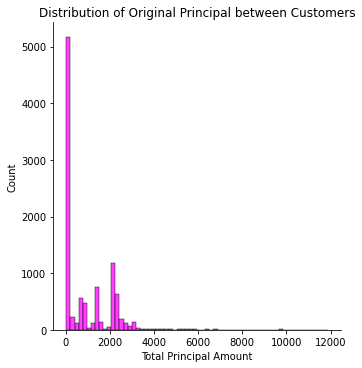

In [37]:
# We can check the distribution of principal between the customers
plt.rcParams['figure.figsize'] = (30,30)
sns.displot(clean_df['  Original Principal  '], color='magenta')
plt.title('Distribution of Original Principal between Customers')
plt.ylabel('Count')
plt.xlabel('Total Principal Amount')
plt.show()

We can see that majority of the debt is not that high, with most of it occuring under $2000.

In [ ]:
# We will continue visulazations using PowerBI, so we export the clean dataframe
from google.colab import files
clean_df.to_csv('output.csv', encoding = 'utf-8-sig') 
files.download('output.csv')

###<strong>PowerBI </strong>

After loading the dataset in PowerBI, I made a dashboard showcasing the bulk of the data. It further boosted my theory that Bank C would be the best option. It seems like the most activity flows through there.
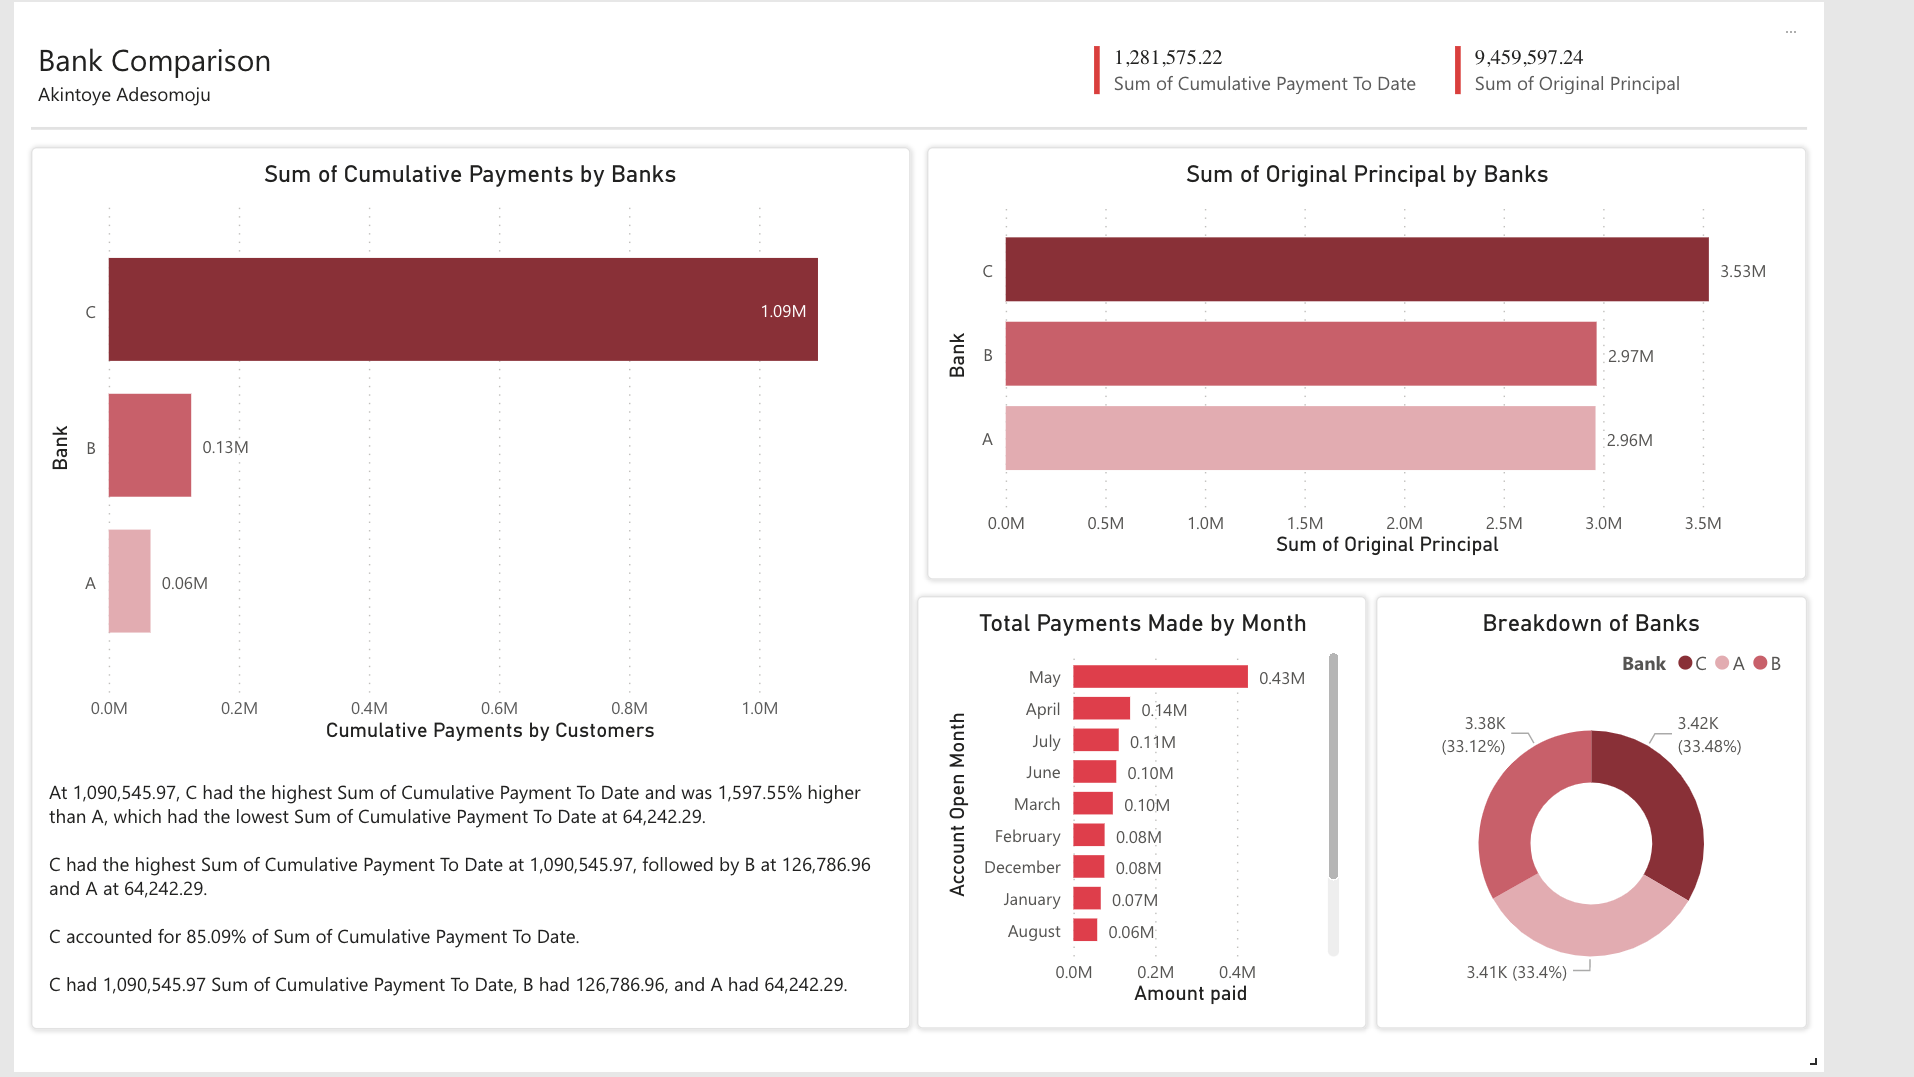

I wanted to share the dashboard so you and will could have a look at it, but I have a limited version of PowerBI and I use a mac so I cannot download the desktop version. I have attached a GIF to show its functionality 
<a href="https://gyazo.com/56f5accecaba638c3ca3449db51ba17d"><img src="https://i.gyazo.com/56f5accecaba638c3ca3449db51ba17d.gif" alt="Project GIF" width="1000"/></a>

###<strong>Summary</strong>

In conclusions we know that:

*   Bank C is the most profitable (the only profitable)
*   Bank C also has the hightest amount of payments from customers and seems to be the least risky



Thank you for your time and for this project. Have a great rest of your day !!